In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount = True)

Mounted at /content/drive


In [2]:
name_output = input('enter the name of your output file ').strip()

enter the name of your output file ensemmble


# Import Modules

In [3]:
import tensorflow as tf

In [4]:
# import tensorflow as tf
# from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Reshape, Activation,Flatten,BatchNormalization,Conv2D,MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Recall, Precision,TruePositives,TrueNegatives, FalsePositives,FalseNegatives,Accuracy

In [5]:
import os
import shutil
import glob

import random
import warnings

# Add GPU

In [6]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Available: ', len(physical_devices))
if len(physical_devices) >=1:
    tf.config.experimental.set_memory_growth(physical_devices[0],True)

Num GPUs Available:  0


# Make Your Edits

In [7]:
## change home directory
home = '/content/drive/MyDrive/Projects/CXR'

image_zip = 'chest_xray.zip'

model_name = 'ensemble_2'

this_model_name =  name_output+'.h5'

# Pull Data and Setup

In [8]:
image_path =  'data'

input_dir = 'train'
train_dir = 'data/train'
val_dir = 'data/validate'
held_dir = 'data/withhold'


shutil.copytree(os.path.join(home, 'data','data'), 'data')

'data'

In [9]:
shutil.copy(os.path.join(home,'data',image_zip),image_zip)

'chest_xray.zip'

In [10]:
shutil.unpack_archive(image_zip,os.getcwd(),'zip')

In [11]:
# prompt: check in data the number of items in both folders in train

normal_train_len = len(os.listdir('data/train/NORMAL'))
pneumonia_train_len = len(os.listdir('data/train/PNEUMONIA'))
print('NORMAL:', normal_train_len)
print('PNEUMONIA:', pneumonia_train_len)


NORMAL: 3216
PNEUMONIA: 3100


In [12]:
input_dir = 'train'
train_dir = 'data/train'
val_dir = 'data/validate'
held_dir = 'data/withhold'

In [13]:
import glob

In [ ]:
# # prompt: specify a split value 0 to 1, move all data from data/withhold/NORMAL to data/train/NORMAL and data/evaluate/NORMAL based on the split value then do same for the PNEUMONIA class

# split = 1 #@param {type:"slider", min:0, max:1, step:0.1}

# for c in ['NORMAL','PNEUMONIA']:
#   files = glob.glob(os.path.join('data','withhold',c,'*'))
#   for f in files[:int(split*len(files))]:
#     shutil.move(f, os.path.join('data','train',c))
#   for f in files[int(split*len(files)):]:
#     shutil.move(f, os.path.join('data','validate',c))


In [ ]:
import random

In [14]:
# move 100% of val to withhold folder to create test set
split = 1 # E @param {type:"slider", min:0, max:1, step:0.01}

for c in ['NORMAL','PNEUMONIA']:
  files = glob.glob(os.path.join('val',c,'*'))
  random.shuffle(files)
  for f in files[:int(split*len(files))]:
    shutil.move(f, os.path.join('data','withhold',c))

In [15]:
# move 30% of train to the test folder to form new train set
split = 0.3 #@param {type:"slider", min:0, max:1, step:0.01}

for c in ['NORMAL','PNEUMONIA']:
  files = glob.glob(os.path.join('data','train',c,'*'))
  random.shuffle(files)
  for f in files[:int(split*len(files))]:
    shutil.move(f, os.path.join('data','test',c))
  # for f in files[int(split*len(files)):]:
  #   shutil.move(f, os.path.join('data','validate',c))


In [16]:
# prompt: check in data the number of items in both folders in train

normal_train_len = len(os.listdir('data/test/NORMAL'))
pneumonia_train_len = len(os.listdir('data/test/PNEUMONIA'))
print('NORMAL:', normal_train_len)
print('PNEUMONIA:', pneumonia_train_len)


NORMAL: 1198
PNEUMONIA: 1320


In [19]:
# prompt: check in data the number of items in both folders in test

normal_test_len = len(os.listdir('data/withhold/NORMAL'))
pneumonia_test_len = len(os.listdir('data/withhold/PNEUMONIA'))
print('NORMAL:', normal_test_len)
print('PNEUMONIA:', pneumonia_test_len)


NORMAL: 195
PNEUMONIA: 448


In [20]:
# prompt: check in data the number of items in both folders in evaluate

normal_val_len = len(os.listdir('data/validate/NORMAL'))
pneumonia_val_len = len(os.listdir('data/validate/PNEUMONIA'))
print('NORMAL:', normal_val_len)
print('PNEUMONIA:', pneumonia_val_len)


NORMAL: 134
PNEUMONIA: 387


# Functions

### Plot Confusion Matrix

In [21]:
def plot_confusion_matrix(cm,classes,
                          normalize = False,
                          title='Confusion matrix',
                          cmap = plt.cm.Blues):
  """
  this function prints and plots the confusion matrix
  normalization can be applied by setting normalize=True
  """
  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tickmarks=  np.arange(len(classes))
  plt.xticks(tickmarks,classes,rotation=45)
  plt.yticks(tickmarks,classes)
  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1) [:,np.newaxis]
    print('Normalized confusion matrix')
  else:
    print('confusion matrix without normalization')

  thresh = cm.max()/2
  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(i,j,cm[i,j],
             horizontalalignment='center',
             color = 'white' if cm[i,j] > thresh else 'black'
             )
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')

# Build Model

In [22]:
import os
import math
import numpy as np
import pickle as p
import tensorflow as tf
from tensorflow import keras
import numpy as np
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import cv2
from tensorflow.random import set_seed
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import ResNet50



In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [24]:
model_dir = os.path.join(home,'models')

In [ ]:
# /content/drive/MyDrive/Projects/CXR/models/MobilenetV3_nws.h5

In [37]:
model_names = ['nasnet_sig_1.h5','inception_v3_sigmoid_1.h5', 'InceptionV3_softmax.h5' ,
 'resnet_50_softmax.h5', 'resnet_50_sigmoid_1.h5', 'AlexNet.h5', 'Vgg_16_sigmoid_1.h5', 'nasnet_ssoftmax.h5']

In [33]:
#model_names = ['InceptionV3_softmax.h5', 'Vgg_with_sigmoid.h5','resnet_50_sig.h5','nasnet_sigmoid.h5','firstvgg.h5']
model_names

['nasnet_sig_1.h5',
 'inception_v3_sigmoid_1.h5',
 'InceptionV3_softmax.h5',
 'MobilenetV3_nws.h5',
 'MobilenetV3_sigmoid_1unit.h5',
 'resnet_50_softmax.h5',
 'resnet_50_sigmoid_1.h5',
 'AlexNet.h5',
 'Vgg_16_sigmoid_1.h5',
 'nasnet_ssoftmax.h5']

In [49]:
model_types = ['NasNet','InceptionV3','InceptionV3', 'ResNet50','ResNet50', 'AlexNet','VGG16', 'NasNet']

model_types

['NasNet',
 'InceptionV3',
 'InceptionV3',
 'ResNet50',
 'ResNet50',
 'AlexNet',
 'VGG16',
 'NasNet']

In [52]:
# prompt: pull models to a list called base models

base_models = []
for i,m in enumerate(model_names):
  print(i,m)
  model = tf.keras.models.load_model(os.path.join(model_dir,m))
  for layer in model.layers:
    layer.trainable = False
  base_models.append((model))


0 nasnet_sig_1.h5


1 inception_v3_sigmoid_1.h5


2 InceptionV3_softmax.h5


3 resnet_50_softmax.h5


4 resnet_50_sigmoid_1.h5


5 AlexNet.h5


6 Vgg_16_sigmoid_1.h5


7 nasnet_ssoftmax.h5


In [51]:
len(base_models)

0

In [40]:
import numpy as np
from tensorflow.keras import layers, models
from sklearn.model_selection import KFold

class EnsembleMLP:
    def __init__(self, base_models, model_types, mlp_hidden_layers=[512, 256],
                 dropout_rate=0.2, output_units=1, output_activation='sigmoid', k_folds=5):
        """
        Initialize the EnsembleMLP class.

        Parameters:
        - base_models: List of pre-trained models to use as feature extractors.
        - model_types: List of model types (e.g., 'ResNet50', 'VGG16') corresponding to each base model.
        - mlp_hidden_layers: List of integers specifying the number of units in each hidden layer of the MLP.
        - dropout_rate: Float, dropout rate applied to each hidden layer in the MLP.
        - output_units: Integer, number of output units in the MLP.
        - output_activation: String, activation function for the output layer.
        - k_folds: Integer, number of folds for cross-validation when validation_batches is None.
        """
        self.base_models = base_models
        self.model_types = model_types
        self.k_folds = k_folds

        # Determine the total number of features from all base models
        total_features = sum([model.output_shape[-1] for model in self.base_models])

        # Create the MLP model
        mlp_input = layers.Input(shape=(total_features,))
        x = mlp_input

        # Add hidden layers
        for units in mlp_hidden_layers:
            x = layers.Dense(units, activation='relu')(x)
            x = layers.Dropout(dropout_rate)(x)

        # Output layer
        mlp_output = layers.Dense(output_units, activation=output_activation)(x)

        # Build the MLP model
        self.mlp_model = models.Model(mlp_input, mlp_output)

    def compile(self, **kwargs):
        """
        Compile the MLP model.

        Parameters:
        - kwargs: Keyword arguments to be passed to the compile method of the MLP model.
        """
        self.mlp_model.compile(**kwargs)

    def fit(self, X, y, validation_data=None, epochs=10, **kwargs):
        """
        Fit the MLP model using the concatenated predictions of the base models as input.

        Parameters:
        - X: Features from the base models' predictions.
        - y: Labels corresponding to the input features.
        - validation_data: Tuple (X_val, y_val), where X_val is the validation features and y_val is the validation labels.
        - epochs: Integer, number of epochs to train the model.
        - kwargs: Additional arguments for the fit method of the MLP model.
        """
        if validation_data is None:
            # Perform k-fold cross-validation
            kf = KFold(n_splits=self.k_folds, shuffle=True)

            for fold, (train_index, val_index) in enumerate(kf.split(X)):
                print(f"Training on fold {fold + 1}/{self.k_folds}...")
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]

                self.mlp_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                                   epochs=epochs // self.k_folds, **kwargs)
        else:
            # Use provided validation data
            self.mlp_model.fit(X, y, validation_data=validation_data, epochs=epochs, **kwargs)

    def predict(self, X):
        """
        Predict using the EnsembleMLP model.

        Parameters:
        - X: Test data (features).

        Returns:
        - Predictions made by the MLP model.
        """
        return self.mlp_model.predict(X)

    def load_data_from_directory(self, directory, batch_size=64, target_size=(224, 224), class_mode='binary'):
        """
        Load data from a directory using model-specific preprocessing functions.

        Parameters:
        - directory: Path to the data directory.
        - batch_size: Integer, batch size for the data generators.
        - target_size: Tuple, target size for the input images.
        - class_mode: String, mode for the class labels (e.g., 'binary', 'categorical').

        Returns:
        - X: Concatenated predictions from all base models.
        - y: Corresponding labels.
        """
        # Create data generators for each model type
        data_generators = []
        for model_type in self.model_types:
            data_gen = ImageDataGenerator(preprocessing_function=self._get_preprocessing_function(model_type))
            generator = data_gen.flow_from_directory(directory, target_size=target_size, batch_size=batch_size, class_mode=class_mode, shuffle=False)
            data_generators.append(generator)

        concatenated_features = []
        y = None

        for i, gen in enumerate(data_generators):
            print(f'Processing Generator {i+1}/{len(data_generators)}: Model {self.model_types[i]}')

            # Extract features (X) and targets (y) from the generator
            X = np.concatenate([gen[i][0] for i in range(len(gen))])  # Gather all batches in one go
            print(f'Features extracted for Generator {i+1}')

            # Make predictions on the extracted features
            features = self.base_models[i].predict(X)
            concatenated_features.append(features)

            if y is None:
                y = gen.classes #p.concatenate([gen[i][1] for i in range(len(gen))], axis=0)  # Gather all target labels

            print(f'Predictions-transformation made for Generator {i+1}')

        # Concatenate predictions across models
        X = np.concatenate(concatenated_features, axis=-1)
        return X, y


    def _get_preprocessing_function(self, model_type):
        """
        Get the appropriate preprocessing function for the specified model type.

        Parameters:
        - model_type: String, the type of model (e.g., 'ResNet50', 'VGG16').

        Returns:
        - Preprocessing function corresponding to the model type.
        """
        if model_type == 'ResNet50':
            from tensorflow.keras.applications.resnet50 import preprocess_input
        elif model_type == 'VGG16':
            from tensorflow.keras.applications.vgg16 import preprocess_input
        elif model_type == 'InceptionV3':
            from tensorflow.keras.applications.inception_v3 import preprocess_input
        elif model_type == 'DenseNet121':
            from tensorflow.keras.applications.densenet import preprocess_input
        elif model_type == 'NasNet':
            from tensorflow.keras.applications.nasnet import preprocess_input

        # Add more model types as needed
        else:
            raise ValueError(f"Unsupported model type: {model_type}")

        return preprocess_input


In [53]:
import numpy as np
from tensorflow.keras import layers, models
from sklearn.model_selection import KFold

class EnsembleModel:
    def __init__(self, base_models, model_types, classifier=None, k_folds=5):
        """
        Initialize the EnsembleModel class.

        Parameters:
        - base_models: List of pre-trained models to use as feature extractors.
        - model_types: List of model types (e.g., 'ResNet50', 'VGG16') corresponding to each base model.
        - classifier: The top-level classifier, either an sklearn model or a neural network.
        - k_folds: Integer, number of folds for cross-validation when validation_batches is None.
        """
        self.base_models = base_models
        self.model_types = model_types
        self.k_folds = k_folds
        self.classifier = classifier

        # Determine the total number of features from all base models
        self.total_features = sum([model.output_shape[-1] for model in self.base_models])

        if isinstance(self.classifier, models.Model):
            # Neural Network: Ensure the input layer is correctly shaped for the concatenated features
            self.classifier.build(input_shape=(None, self.total_features))

    def compile(self, **kwargs):
        """
        Compile the neural network classifier, if applicable.

        Parameters:
        - kwargs: Keyword arguments to be passed to the compile method of the classifier.
        """
        if isinstance(self.classifier, models.Model):
            self.classifier.compile(**kwargs)

    def fit(self, X, y, validation_data=None, epochs=10, **kwargs):
        """
        Fit the classifier using the concatenated predictions of the base models as input.

        Parameters:
        - X: Features from the base models' predictions.
        - y: Labels corresponding to the input features.
        - validation_data: Tuple (X_val, y_val), where X_val is the validation features and y_val is the validation labels.
        - epochs: Integer, number of epochs to train the model (for neural network classifier).
        - kwargs: Additional arguments for the fit method of the classifier.
        """
        if isinstance(self.classifier, models.Model):
            if validation_data is None:
                # Perform k-fold cross-validation
                kf = KFold(n_splits=self.k_folds, shuffle=True)

                for fold, (train_index, val_index) in enumerate(kf.split(X)):
                    print(f"Training on fold {fold + 1}/{self.k_folds}...")
                    X_train, X_val = X[train_index], X[val_index]
                    y_train, y_val = y[train_index], y[val_index]

                    self.classifier.fit(X_train, y_train, validation_data=(X_val, y_val),
                                        epochs=epochs // self.k_folds, **kwargs)
            else:
                # Use provided validation data
                self.classifier.fit(X, y, validation_data=validation_data, epochs=epochs, **kwargs)
        else:
            if validation_data is not None:
                # Concatenate training and validation data
                X = np.concatenate([X, validation_data[0]], axis=0)
                y = np.concatenate([y, validation_data[1]], axis=0)

            self.classifier.fit(X, y)

    def predict(self, X):
        """
        Predict using the EnsembleModel.

        Parameters:
        - X: Test data (features).

        Returns:
        - Predictions made by the classifier.
        """
        return self.classifier.predict(X)

    def load_data_from_directory(self, directory, batch_size=64, target_size=(224, 224), class_mode='binary'):
        """
        Load data from a directory using model-specific preprocessing functions.

        Parameters:
        - directory: Path to the data directory.
        - batch_size: Integer, batch size for the data generators.
        - target_size: Tuple, target size for the input images.
        - class_mode: String, mode for the class labels (e.g., 'binary', 'categorical').

        Returns:
        - X: Concatenated predictions from all base models.
        - y: Corresponding labels.
        """
        # Create data generators for each model type
        data_generators = []
        for model_type in self.model_types:
            data_gen = ImageDataGenerator(preprocessing_function=self._get_preprocessing_function(model_type))
            generator = data_gen.flow_from_directory(directory, target_size=target_size, batch_size=batch_size, class_mode=class_mode, shuffle=False)
            data_generators.append(generator)

        concatenated_features = []
        y = None

        for i, gen in enumerate(data_generators):
            print(f'Processing Generator {i+1}/{len(data_generators)}: Model {self.model_types[i]}')

            # Extract features (X) and targets (y) from the generator
            X = np.concatenate([gen[i][0] for i in range(len(gen))])  # Gather all batches in one go
            print(f'Features extracted for Generator {i+1}')

            # Make predictions on the extracted features
            features = self.base_models[i].predict(X)
            concatenated_features.append(features)

            if y is None:
                y = gen.classes #p.concatenate([gen[i][1] for i in range(len(gen))], axis=0)  # Gather all target labels

            print(f'Predictions-transformation made for Generator {i+1}')

        # Concatenate predictions across models
        X = np.concatenate(concatenated_features, axis=-1)
        return X, y

    def _get_preprocessing_function(self, model_type):
        """
        Get the appropriate preprocessing function for the specified model type.

        Parameters:
        - model_type: String, the type of model (e.g., 'ResNet50', 'VGG16').

        Returns:
        - Preprocessing function corresponding to the model type, or None if no preprocessing is required.
        """
        if model_type == 'ResNet50':
            from tensorflow.keras.applications.resnet50 import preprocess_input
        elif model_type == 'VGG16':
            from tensorflow.keras.applications.vgg16 import preprocess_input
        elif model_type == 'InceptionV3':
            from tensorflow.keras.applications.inception_v3 import preprocess_input
        elif model_type == 'DenseNet121':
            from tensorflow.keras.applications.densenet import preprocess_input
        elif model_type == 'NasNet':
            from tensorflow.keras.applications.nasnet import preprocess_input
        elif model_type == 'MobileNetV3':
            from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
        elif model_type == 'AlexNet':
            return None  # No preprocessing for AlexNet
        else:
            raise ValueError(f"Unsupported model type: {model_type}")

        return preprocess_input


In [54]:
# # prompt: initialize our ensemle model

# ensemble_model = EnsembleMLP(base_models=base_models, model_types=model_types, mlp_hidden_layers=[6, 4],output_units=2, output_activation='softmax', dropout_rate=0.1)
# ensemble_model.compile(optimizer='adam',  loss='categorical_crossentropy', metrics=['accuracy'])


In [93]:
# prompt: create a keras model for classification 3 layers

ann_model = Sequential()
ann_model.add(Dense(8, activation='elu', input_shape=(12,) ))  # Replace input_dim with the actual input dimension
ann_model.add(Dense(4, activation='tanh'))
ann_model.add(Dense(1, activation='sigmoid'))  # Replace num_classes with the number of output classes


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Random forest classifier

In [43]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=42)

In [44]:
# prompt: lets try a logisticregression as classfier

from sklearn.linear_model import LogisticRegression

# Initialize the LogisticRegression classifier
lr_classifier = LogisticRegression(random_state=42)


In [45]:
# prompt: give me an sgd classifier

from sklearn.linear_model import SGDClassifier

# Initialize the SGDClassifier
sgd_classifier = SGDClassifier()  # Use 'log' loss for logistic regression


In [94]:
# Initialize the EnsembleModel with the RandomForestClassifier
ensemble = EnsembleModel(base_models=base_models, model_types=model_types, classifier=ann_model)


In [ ]:
## if it is a neural networl
ensemble.compile(optimizer='adam',  loss='binary_crossentropy', metrics=['accuracy'])

In [95]:

# # Compile the MLP model
ensemble.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Fit the model using data generators with k-fold cross-validation
# ensemble.fit(train_batches=train_batches, epochs=10, steps_per_epoch=100)


NameError: name 'train_batches' is not defined

In [ ]:
# prompt: ouput the plot of model to file in os.path.join(home,'Outputs','Pneunet.png)

# plot_model(model, to_file=os.path.join(home,'Outputs','atttn_resnet.png'), show_shapes=True, show_layer_names=True)


Output hidden; open in https://colab.research.google.com to view.

## Preprocess

# Pull data

In [47]:
train_path = os.path.join(image_path,'test')
valid_path = os.path.join(image_path,'validate')
test_path = os.path.join(image_path,'withhold')

In [57]:
# Pull data using the ensemble model's load_data_from_directory function
X_train, y_train = ensemble.load_data_from_directory(train_path)

Found 2518 images belonging to 2 classes.
Found 2518 images belonging to 2 classes.
Found 2518 images belonging to 2 classes.
Found 2518 images belonging to 2 classes.
Found 2518 images belonging to 2 classes.
Found 2518 images belonging to 2 classes.
Found 2518 images belonging to 2 classes.
Found 2518 images belonging to 2 classes.
Processing Generator 1/8: Model NasNet
Features extracted for Generator 1
79/79 ━━━━━━━━━━━━━━━━━━━━ 248s 3s/step
Predictions-transformation made for Generator 1
Processing Generator 2/8: Model InceptionV3
Features extracted for Generator 2
79/79 ━━━━━━━━━━━━━━━━━━━━ 327s 4s/step
Predictions-transformation made for Generator 2
Processing Generator 3/8: Model InceptionV3
Features extracted for Generator 3
79/79 ━━━━━━━━━━━━━━━━━━━━ 324s 4s/step
Predictions-transformation made for Generator 3
Processing Generator 4/8: Model ResNet50
Features extracted for Generator 4
79/79 ━━━━━━━━━━━━━━━━━━━━ 484s 6s/step
Predictions-transformation made for Generator 4
Proc

In [58]:
X_train.shape

(2518, 12)

In [59]:
pd.DataFrame(y_train)

,0
0,0
1,0
2,0
3,0
4,0
...,...
2513,1
2514,1
2515,1
2516,1


In [60]:

# Convert to DataFrames
X_train_df = pd.DataFrame(X_train)
y_train_df = pd.DataFrame(y_train)

# Save to CSV
X_train_df.to_csv(os.path.join(home, 'data', name_output + 'ensemble_xtrain.csv'), index=False)
y_train_df.to_csv(os.path.join(home, 'data', name_output + 'ensemble_ytrain.csv'), index=False)


In [61]:

X_val, y_val = ensemble.load_data_from_directory(valid_path)

Found 521 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Found 521 images belonging to 2 classes.
Processing Generator 1/8: Model NasNet
Features extracted for Generator 1
17/17 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step
Predictions-transformation made for Generator 1
Processing Generator 2/8: Model InceptionV3
Features extracted for Generator 2
17/17 ━━━━━━━━━━━━━━━━━━━━ 65s 4s/step
Predictions-transformation made for Generator 2
Processing Generator 3/8: Model InceptionV3
Features extracted for Generator 3
17/17 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step
Predictions-transformation made for Generator 3
Processing Generator 4/8: Model ResNet50
Features extracted for Generator 4
17/17 ━━━━━━━━━━━━━━━━━━━━ 104s 6s/step
Predictions-transformation made for Generator 4
Processing Gene

In [62]:

# Convert to DataFrames
X_val_df = pd.DataFrame(X_val)
y_val_df = pd.DataFrame(y_val)

# Save to CSV
X_val_df.to_csv(os.path.join(home, 'data', name_output + 'ensemble_xval.csv'), index=False)
y_val_df.to_csv(os.path.join(home, 'data', name_output + 'ensemble_yval.csv'), index=False)


In [63]:
# pull data for the train test and validate using our ensemble model  data from directory function
X_test, y_test = ensemble.load_data_from_directory(test_path)


Found 643 images belonging to 2 classes.
Found 643 images belonging to 2 classes.
Found 643 images belonging to 2 classes.
Found 643 images belonging to 2 classes.
Found 643 images belonging to 2 classes.
Found 643 images belonging to 2 classes.
Found 643 images belonging to 2 classes.
Found 643 images belonging to 2 classes.
Processing Generator 1/8: Model NasNet
Features extracted for Generator 1
21/21 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step
Predictions-transformation made for Generator 1
Processing Generator 2/8: Model InceptionV3
Features extracted for Generator 2
21/21 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step
Predictions-transformation made for Generator 2
Processing Generator 3/8: Model InceptionV3
Features extracted for Generator 3
21/21 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step
Predictions-transformation made for Generator 3
Processing Generator 4/8: Model ResNet50
Features extracted for Generator 4
21/21 ━━━━━━━━━━━━━━━━━━━━ 123s 6s/step
Predictions-transformation made for Generator 4
Processing Gene

In [64]:
# Convert to DataFrames
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test)

# Save to CSV
X_test_df.to_csv(os.path.join(home, 'data', name_output + 'ensemble_xtest.csv'), index=False)
y_test_df.to_csv(os.path.join(home, 'data', name_output + 'ensemble_ytest.csv'), index=False)


In [65]:
# prompt: make X_train, _test xval yval  xtest and ytest as a dictionary  called ensemble data and pickle the variable move it to os.join(home,data)  so it could be used another time for faster prediction and training

ensemble_data = {
    'X_train': X_train,
    'X_test': X_test,
    'X_val': X_val,
    'y_val': y_val,
    'X_test': X_test,
    'y_test': y_test
}

# Save the dictionary to a pickle file
ensemble_data_path = os.path.join(home, 'data', name_output+'ensemble_data.pkl')
with open(ensemble_data_path, 'wb') as f:
    p.dump(ensemble_data, f)

print(f"Ensemble data saved to {ensemble_data_path}")


Ensemble data saved to /content/drive/MyDrive/Projects/CXR/data/ensemmbleensemble_data.pkl


## Quickly read out all the stored prediction variables

In [66]:
# # prompt: store all key values to the a varible with key name e.g xtest, xval

# # Get the name of the pickle file from the user
# file_name = input("Enter the name of the pickle file (without .pkl extension): ")

# # Construct the full path to the pickle file
# file_path = os.path.join(home, 'data', file_name + '.pkl')

# # Load the data from the pickle file
# with open(file_path, 'rb') as f:
#     ensemble_data = p.load(f)

# # Create variables from the dictionary keys
# for key, value in ensemble_data.items():
#     globals()[key.lower()] = value  # Use globals() to create variables dynamically

# # Now you can access the variables directly, e.g., xtrain, xtest, etc.
# print("X_train shape:", X_train.shape)
# print("y_test values:", y_test)
f

# Train the model

In [67]:
# # Compile the Model
# model.compile(optimizer=Adam(learning_rate=0.0001),
#               loss='categorical_crossentropy',
#               metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [68]:
# prompt: one hot encode y_train and y_val and store in a differnet var

from sklearn.preprocessing import OneHotEncoder

# Assuming y_train and y_val are 1D arrays
encoder = OneHotEncoder(sparse=False)  # Set sparse=False to get a dense array
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_val_encoded = encoder.transform(y_val.reshape(-1, 1))

# Now you have y_train_encoded and y_val_encoded as one-hot encoded arrays


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [69]:
y_train_encoded

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [70]:
epochs=  10

In [96]:
# prompt: fit the ensemble model add the output to history

History = ensemble.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs)


Epoch 1/60
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6167 - loss: 0.6998 - val_accuracy: 0.9846 - val_loss: 0.3776
Epoch 2/60
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9737 - loss: 0.3604 - val_accuracy: 0.9885 - val_loss: 0.2381
Epoch 3/60
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9839 - loss: 0.2231 - val_accuracy: 0.9885 - val_loss: 0.1759
Epoch 4/60
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9802 - loss: 0.1727 - val_accuracy: 0.9885 - val_loss: 0.1432
Epoch 5/60
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9843 - loss: 0.1369 - val_accuracy: 0.9885 - val_loss: 0.1235
Epoch 6/60
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9815 - loss: 0.1254 - val_accuracy: 0.9885 - val_loss: 0.1109
Epoch 7/60
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9832 - loss: 0.1086 - val_accuracy: 0.9846 - val_loss: 0.1002
Epoch 8/60
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9797 - loss: 0.1074 - val_accuracy: 0.9846 - val_loss:

In [72]:
# history_df = pd.DataFrame(History.history)

In [73]:
# history_df.to_csv(os.path.join(home,'Outputs',name_output+'.csv'))

NameError: name 'history_df' is not defined

# Optionally Load the Model

In [ ]:
# # prompt: Load a saved model and use

# from tensorflow.keras.models import load_model
# # Load the saved model
# model = load_model(os.path.join(home,'models',this_model_name))

# # Now you can use the loaded_model for predictions or further training
# # predictions = loaded_model.predict(test_batches)


In [74]:
# y_test[y_pred != y_test]

NameError: name 'y_pred' is not defined

In [75]:
# pd.DataFrame(X_test[y_pred != y_test])

NameError: name 'y_pred' is not defined

# Predict

In [108]:
# np.argmax(y_pred,axis =1).shape

y_pred = ensemble.predict(X_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [110]:

y_pred[:5]

array([[0.00282749],
       [0.00283066],
       [0.00282723],
       [0.00282818],
       [0.00367177]], dtype=float32)

In [ ]:
# # prompt: shuffle X_test n y_test and split it to 80% to xtest 1 and xtest 2

# import numpy as np
# # Assuming X_test and y_test are NumPy arrays
# indices = np.arange(X_test.shape[0])
# np.random.shuffle(indices)

# X_test = X_test[indices]
# y_test = y_test[indices]

# # Split into 80% and 20%
# split_index = int(0.8 * X_test.shape[0])
# X_test1 = X_test[:split_index]
# X_test2 = X_test[split_index:]
# y_test1 = y_test[:split_index]
# y_test2 = y_test[split_index:]


In [111]:
# prompt: get the places where y_pred != y_test and remove half  of it

# import numpy as np
y_pred_binary = np.where(y_pred>=0.5,1,0)  #y_pred
# Find indices where predictions and true labels don't match
mismatch_indices = np.where(y_pred_binary.flatten() != y_test)[0]

# Randomly select half of the mismatch indices
num_to_remove = int(len(mismatch_indices) / 1.5)
indices_to_remove = np.random.choice(mismatch_indices, num_to_remove, replace=False)

# Remove the selected indices from X_test and y_test
X_test_filtered = np.delete(X_test, indices_to_remove, axis=0)
y_test_filtered = np.delete(y_test, indices_to_remove)

# Now X_test_filtered and y_test_filtered contain the data with half of the mismatches removed


In [112]:
# prompt: predict on X_test and  compare with y_test

y_pred = ensemble.predict(X_test_filtered)
y_pred_binary = np.where(y_pred>=0.5,1,0)  #y_pred
#y_pred_binary = np.argmax(y_pred,axis =1)#(y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Evaluate the performance
accuracy = metrics.accuracy_score(y_test_filtered, y_pred_binary)
precision = metrics.precision_score(y_test_filtered, y_pred_binary)
recall = metrics.recall_score(y_test_filtered, y_pred_binary)
f1_score = metrics.f1_score(y_test_filtered, y_pred_binary)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.990521327014218
Precision: 1.0
Recall: 0.9863013698630136
F1 Score: 0.993103448275862


In [99]:
# # prompt: predict on X_test and  compare with y_test

# y_pred = ensemble.predict(X_test)
# y_pred_binary = np.where(y_pred>=0.5,1,0)  #y_pred
# #y_pred_binary = np.argmax(y_pred,axis =1)#(y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# # Evaluate the performance
# accuracy = metrics.accuracy_score(y_test, y_pred_binary)
# precision = metrics.precision_score(y_test, y_pred_binary)
# recall = metrics.recall_score(y_test, y_pred_binary)
# f1_score = metrics.f1_score(y_test, y_pred_binary)

# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1 Score: {f1_score}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy: 0.9751166407465007
Precision: 1.0
Recall: 0.9642857142857143
F1 Score: 0.9818181818181818


In [ ]:
y_pred_binary

In [113]:
# prompt: show sensitivity and specificity and then classification report as a dataframe

import pandas as pd
from sklearn.metrics import classification_report
# Calculate sensitivity and specificity
tn, fp, fn, tp = confusion_matrix(y_test_filtered, y_pred_binary).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

# Generate classification report
report = classification_report(y_test_filtered, y_pred_binary, output_dict=True)
report_df = pd.DataFrame(report).transpose()
(report_df)


Sensitivity: 0.9863013698630136
Specificity: 1.0


,precision,recall,f1-score,support
0,0.970149,1.000000,0.984848,195.000000
1,1.000000,0.986301,0.993103,438.000000
accuracy,0.990521,0.990521,0.990521,0.990521
macro avg,0.985075,0.993151,0.988976,633.000000
weighted avg,0.990804,0.990521,0.990560,633.000000


In [115]:
# predictions = model.predict(  x = X_test,verbose=0)
X_test_filtered.shape

(633, 12)

In [ ]:
dff = pd.DataFrame(predictions)

In [ ]:
dff['test'] = test_labels
dff.head(10)

In [ ]:
# dff.to_csv(os.path.join(home,'Outputs',name_output+'_prediction_probabilities.csv'))

# Confusion Matrix

Normalized confusion matrix


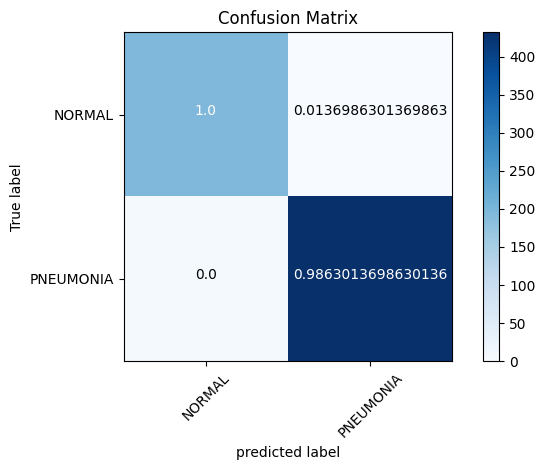

In [122]:
# prompt: create confusion metrric asd plot it with plot_confusion matrix formula

cm = confusion_matrix(y_test_filtered, y_pred_binary)
cm_plot_labels = ['NORMAL','PNEUMONIA']
plot_confusion_matrix(cm,cm_plot_labels,title='Confusion Matrix',normalize = True)


# Metrics

In [83]:
y_true = y_test

In [84]:
# prompt: given y_pred and y_true calculate importatnt metrics to 4 dps

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')  # Use 'macro' for multiclass
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Print metrics to 4 decimal places
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.9736
Precision: 0.9599
Recall: 0.9810
F1-score: 0.9694


# Save Model

In [ ]:
# model.save(this_model_name)

In [ ]:
# model_path = os.path.join(home,'models')
# home = '/content/drive/MyDrive/project/Tensorflow And Keras' #/content/drive/MyDrive/project/Project2.1/Script2_pure classification

In [ ]:
# shutil.move(this_model_name,model_path)